This notebook will explore the statistics of the NBA players in the 2024-2025 season. Then we will compare them with the corresponding year's salary data, and see who really deserved their payment that year.

First, we get our statistics data and clean it.

This project uses two main datasets:

- Kaggle: NBA player salary data (USD)
- Basketball Reference: Player performance statistics

The player statistics data from Basketball Reference had all the players' names right, with the special letters in their names. But Kaggle's salary data had all the names with only the Latin alphabet. This further resulted in these names not appearing at all in the list. Therefore, I have changed all the special letters in the statistics data to their Latin counterparts by hand, preventing any data leak.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


stats_df = pd.read_csv("data/player_statistics.csv")
stats_df['Player'] = stats_df['Player'].str.strip()
numeric_cols = ['Age', 'MP', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
stats_df.dropna(subset=numeric_cols, inplace=True)
for col in numeric_cols:
    stats_df[col] = pd.to_numeric(stats_df[col])
stats_df.head()


,Rk,Player,Age,Pos,MP,TRB,AST,STL,BLK,TOV,PTS,Player-additional
0,1,Precious Achiuwa,25,C,1170,9.8,1.7,1.4,1.3,1.4,11.7,achiupr01
1,2,Steven Adams,31,C,794,14.8,3.0,1.0,1.3,2.4,10.2,adamsst01
2,3,Bam Adebayo,27,C,2674,10.1,4.5,1.3,0.7,2.2,19.0,adebaba01
3,4,Ochai Agbaji,24,SG,1739,5.0,2.0,1.2,0.6,1.1,13.8,agbajoc01
4,5,Santi Aldama,24,PF,1660,9.0,4.1,1.1,0.6,1.5,17.6,aldamsa01


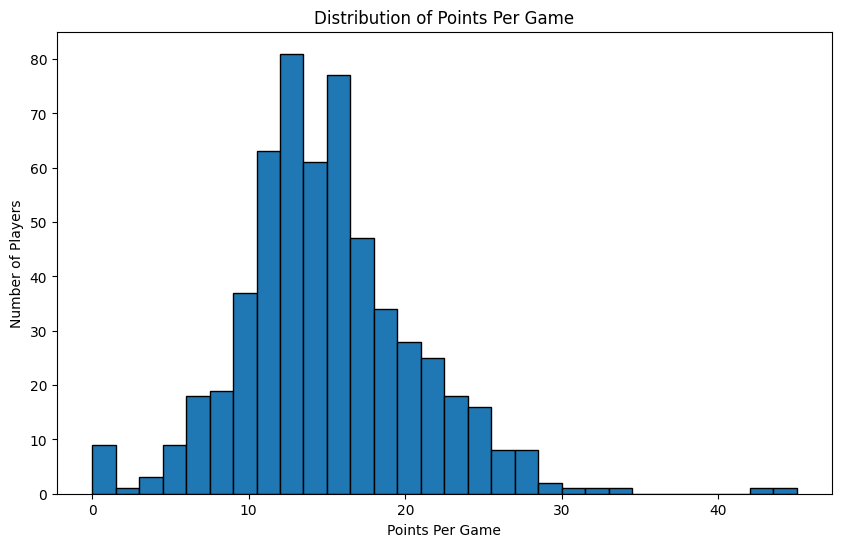

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(stats_df['PTS'], bins=30, edgecolor='black')
plt.xlabel("Points Per Game")
plt.ylabel("Number of Players")
plt.title("Distribution of Points Per Game")
plt.show()

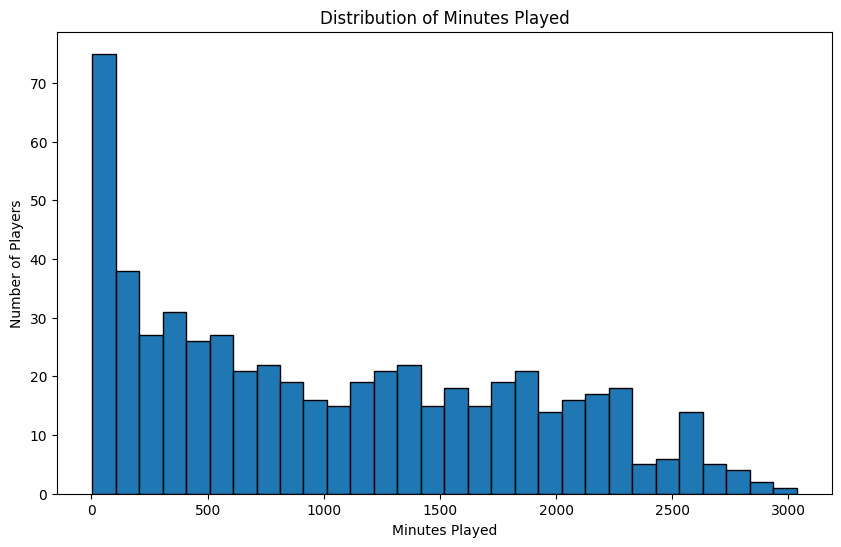

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(stats_df['MP'], bins=30, edgecolor='black')
plt.xlabel("Minutes Played")
plt.ylabel("Number of Players")
plt.title("Distribution of Minutes Played")
plt.show()

The plots above show that the performance metrics are substantial among players. Both minutes played and points scored per game are concentrated among starter and star players. This encourages us to use value-based metrics later on.

Now we get our salary data, and also clean it.

In [36]:
salary_df = pd.read_csv("data/player_salaries.csv")
salary_df['Salary_USD'] = (salary_df['Salary'].astype(str).str.replace('$', '').str.replace(',', '').str.strip().astype(float))
salary_df.drop_duplicates(subset=['Player'], keep='first', inplace=True) 
salary_df['Player'] = salary_df['Player'].str.strip()
salary_df.dropna(subset=['Salary_USD'], inplace=True)
salary_df.head()


,Player,Team,Salary,Salary_USD
0,Stephen Curry,GSW,"$55,761,216",55761216.0
1,Joel Embiid,PHI,"$51,415,938",51415938.0
2,Nikola Jokic,DEN,"$51,415,938",51415938.0
3,Kevin Durant,PHO,"$51,179,021",51179021.0
4,Bradley Beal,PHO,"$50,203,930",50203930.0


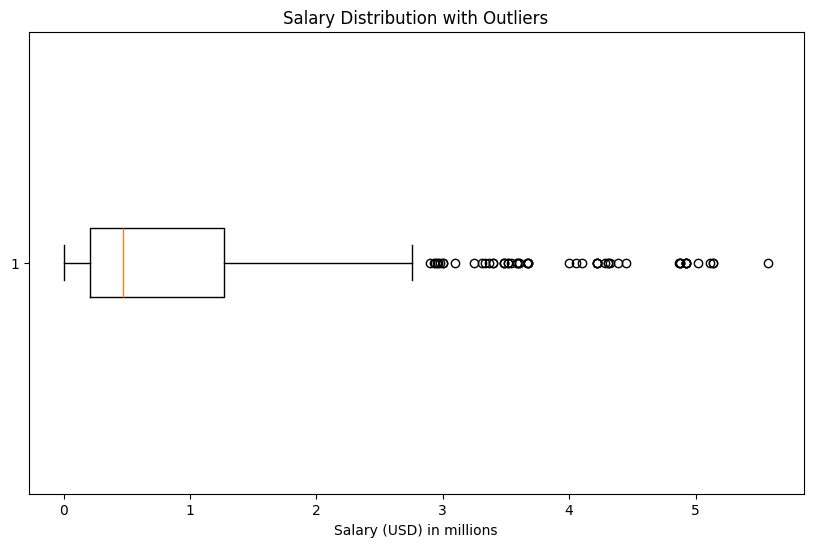

In [37]:
plt.figure(figsize=(10, 6))
plt.boxplot(salary_df['Salary_USD'] / 1e7, vert=False)
plt.xlabel("Salary (USD) in millions")
plt.title("Salary Distribution with Outliers")
plt.show()

The data distribution in the above plot is highly right-skewed with a small number of players earning huge amounts of money compared to the rest. The presence of such large outliers suggest that mean salary alone may be misleading, and we may have to consider a median-used approach later on the study.

We will now combine the two datasets and create two features to analyze the performance of the players and the ratio of their performance/pay. Namely Composite Performance Index (CPI) and Value Per Dollar (VPD). For an unbiased analysis, we remove the players who has no data for their salaries and players who have played less than 500 minutes.

In [38]:
combined_df = pd.merge(stats_df, salary_df[['Player', 'Team', 'Salary_USD']])
combined_df['CPI'] = (combined_df['PTS'] + combined_df['TRB'] + combined_df['AST'] + combined_df['STL'] + combined_df['BLK'] - combined_df['TOV'])
combined_df['VPD'] = (combined_df['CPI'] / combined_df['Salary_USD']) * 1_000_000
df_clean = combined_df.copy()
df_clean = df_clean[(df_clean["MP"] >= 500) & (df_clean["Salary_USD"] > 0)].copy()
df_clean = df_clean[~df_clean["Salary_USD"].isna()]
df_clean.shape

df_clean.head()

,Rk,Player,Age,Pos,MP,TRB,AST,STL,BLK,TOV,PTS,Player-additional,Team,Salary_USD,CPI,VPD
0,1,Precious Achiuwa,25,C,1170,9.8,1.7,1.4,1.3,1.4,11.7,achiupr01,NYK,6000000.0,24.5,4.083333
1,2,Steven Adams,31,C,794,14.8,3.0,1.0,1.3,2.4,10.2,adamsst01,HOU,12600000.0,27.9,2.214286
2,3,Bam Adebayo,27,C,2674,10.1,4.5,1.3,0.7,2.2,19.0,adebaba01,MIA,34848340.0,33.4,0.958439
3,4,Ochai Agbaji,24,SG,1739,5.0,2.0,1.2,0.6,1.1,13.8,agbajoc01,TOR,4310280.0,21.5,4.988075
4,5,Santi Aldama,24,PF,1660,9.0,4.1,1.1,0.6,1.5,17.6,aldamsa01,MEM,3960531.0,30.9,7.801984


Scatter Plot -- DPI vs Salary

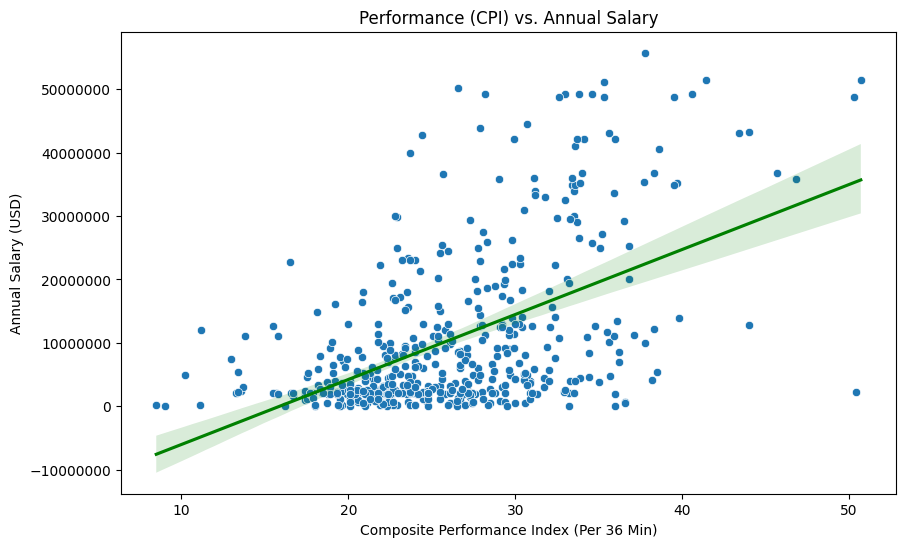

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CPI', y='Salary_USD', data=combined_df)
sns.regplot(x='CPI', y='Salary_USD', data=combined_df, scatter=False, color='green')
plt.title('Performance (CPI) vs. Annual Salary')
plt.xlabel('Composite Performance Index (Per 36 Min)')
plt.ylabel('Annual Salary (USD)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Histogram Plot -- Distribution of Salaries

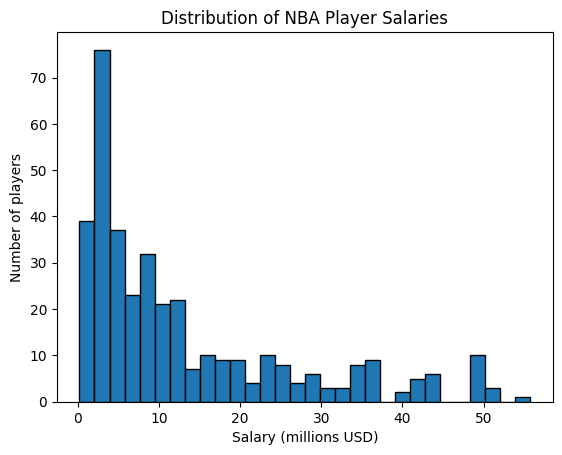

In [40]:
plt.hist(df_clean["Salary_USD"] / 1e6, bins=30, edgecolor='black')
plt.xlabel("Salary (millions USD)")
plt.ylabel("Number of players")
plt.title("Distribution of NBA Player Salaries")
plt.show()

Bar Plot -- Distribution of Average Salaries Between Positions

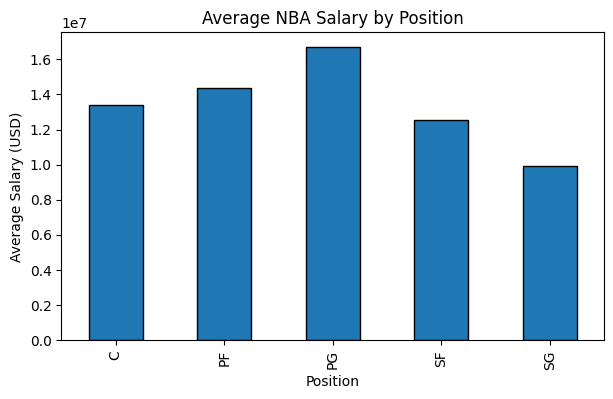

In [41]:
plt.figure(figsize=(7,4))
df_clean.groupby('Pos')['Salary_USD'].mean().plot(kind='bar', edgecolor='black')
plt.ylabel("Average Salary (USD)")
plt.xlabel("Position")
plt.title("Average NBA Salary by Position")
plt.show()


Boxplot -- Shows VPD and CPI by Players Positions; Centers, Forwards and Guards

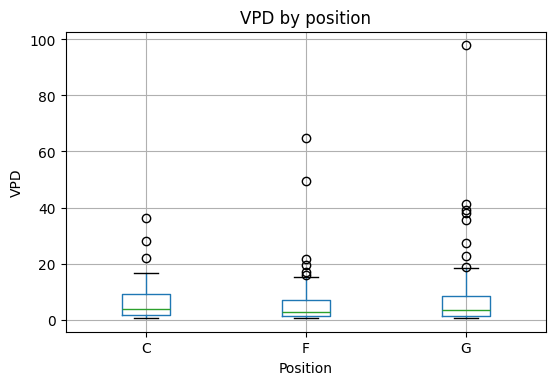

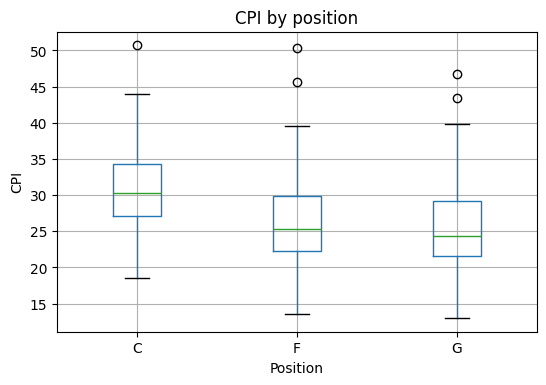

In [42]:
def simplify_pos(pos):
    if isinstance(pos, str):
        if 'G' in pos: return 'G'
        if 'F' in pos: return 'F'
        if 'C' in pos: return 'C'
    return None

df_clean['Pos_simple'] = df_clean['Pos'].apply(simplify_pos)

df_clean.boxplot(column='VPD', by='Pos_simple', figsize=(6,4))
plt.title("VPD by position")
plt.suptitle("")
plt.xlabel("Position")
plt.ylabel("VPD")
plt.show()

df_clean.boxplot(column='CPI', by='Pos_simple', figsize=(6,4))
plt.title("CPI by position")
plt.suptitle("")
plt.xlabel("Position")
plt.ylabel("CPI")
plt.show()

### Hypothesis Tests

Hypothesis Test 1: VPD differs by position
- H₀: Mean VPD is the same for guards, forwards and centers. 
- H₁: At least one position has a different mean VPD.

In [43]:
anova_df = df_clean.dropna(subset=['VPD', 'Pos_simple'])

groups = [
    anova_df.loc[anova_df['Pos_simple'] == 'G', 'VPD'],
    anova_df.loc[anova_df['Pos_simple'] == 'F', 'VPD'],
    anova_df.loc[anova_df['Pos_simple'] == 'C', 'VPD'],
]

f_stat, p_val = stats.f_oneway(*groups)
print("F-stat:", f_stat, "p-value:", p_val)

if p_val < 0.05:
    print("Reject H₀: VPD does differ by position.")
else:
    print("Fail to reject H₀: No significant difference found.")


F-stat: 0.6808320398609015 p-value: 0.5068390575552826
Fail to reject H₀: No significant difference found.


### Interpretation of the Result

Since we got a slightly large p value, we can see that the Value Per Dollar for different positions does not differ much.

Hypothesis Test 2: Top VPD players are underpaid vs others
- H₀: There is no significant difference in average salary between high-value players and overpaid players.
- H₁: There is a significant salary difference between high-value players and overpaid players.

In [44]:
from scipy.stats import ttest_ind

vpd_q25 = df_clean['VPD'].quantile(0.25)
vpd_q75 = df_clean['VPD'].quantile(0.75)
cpi_q25 = df_clean['CPI'].quantile(0.25)
cpi_q75 = df_clean['CPI'].quantile(0.75)

value_players = df_clean[(df_clean['VPD'] >= vpd_q75) & (df_clean['CPI'] <= cpi_q25)]
overpaid_players = df_clean[(df_clean['VPD'] <= vpd_q25) & (df_clean['CPI'] >= cpi_q75)]

t_stat, p_value = ttest_ind(overpaid_players['Salary_USD'],value_players['Salary_USD'],equal_var=False)


if p_value < 0.05:
    print("Reject H₀: There is a significant difference in average salary between high-value players and overpaid players.")
else:
    print("Fail to reject H₀: No significant difference found.")


Reject H₀: There is a significant difference in average salary between high-value players and overpaid players.


Interpretation of the Result

With the above test, we can see that p value is so small that there is a significant difference of salary between the high-valued players and overpaid players' average salaries.


Hypothesis Test 3: The correlation between CPI and Salary
- H₀: There is no correlation between CPI and Salary.
- H₁: There is a significant correlation between CPI and Salary.

In [46]:
corr_coef = df_clean['CPI'].corr(df_clean['Salary_USD'])
n = len(df_clean)
t_stat = corr_coef * np.sqrt((n - 2) / (1 - corr_coef ** 2))

print("Pearson Correlation Coefficient:", round(corr_coef, 4))
print("Sample Size (n):", n)
print("T-statistic:", round(t_stat, 4))

if abs(corr_coef) > 0.5:
    print("Reject H₀: There is a strong correlation.")
else:
    print("Fail to reject H₀: The correlation is weak or non-existent.")

Pearson Correlation Coefficient: 0.5695
Sample Size (n): 367
T-statistic: 13.2363
Reject H₀: There is a strong correlation.


Interpretation of the Result: As we can see, according to the value I've created 'CPI' the correlation between CPI and Salary actually does exist, but our study will still continue to find out if there are some players that have low CPI & high salary

### Conclusion

With the above EDA and tests, this study concluded that the VPD does not really change between different positions, so different positions shine in different playstyles equally.

But we also see that in the second hypothesis test, the top VPD players are slightly underpaid than the top overpaid players. 

It must be noted that a lot of things may affect a player's salary for the team. Their age, experience, fame, out-of-court activities; all these aspects must be taken into consideration before deciding what salary a player deserves. This study compares only their performances in the court and no other factors.

Another thing is that this study focuses only for the 2024-2025 NBA season. Some players may shine in certain seasons, and some also might have an unlucky performance in a certain year. Therefore, this study only shows the metrics of the respected year, and conducting analysis on multiple years at once may yield more accurate results.